# Data chunking and image generation

For this project we are using Python, and Jupyter Notebooks hosted on Google Colab. Any Jupyter engine will can be used, but it will require adjustmets to this initial setup to be able to access the raw data and the helper tools. 

To keep the notebook clean, all the implementation details are hidden in a set of helper functions in the file `deeppredict_tools.py`

### Prerequisites for running this Notebook on Google Colab 

We need to mount a Google Drive folder called `deeppredict`, which has the same structure and contents as the repository at https://github.com/dimitardi/deep-predict. 

And the matlab raw data files in the subfolder `DEEPPREDICT_HOME/dataset` (see `deeppredict_0_download_raw_data.ipynb` for how to download these files)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

DEEPPREDICT_HOME = '/content/gdrive/My Drive/deeppredict'

# add the home folder to the python path to be able to import and use the included code
import sys
sys.path.append(DEEPPREDICT_HOME)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install --upgrade -q -r '/content/gdrive/My Drive/deeppredict/requirements.txt'

import skimage as sk
# explicitly check the sci-kit image version
# currently colab has the 0.13 by default, which is too old. It should be at least >= 0.14
sk.__version__

    100% |████████████████████████████████| 706kB 20.7MB/s 
    100% |████████████████████████████████| 2.8MB 11.2MB/s 
    100% |████████████████████████████████| 61kB 23.0MB/s 
    100% |████████████████████████████████| 286kB 27.1MB/s 
    100% |████████████████████████████████| 51kB 18.5MB/s 
    100% |████████████████████████████████| 1.6MB 17.7MB/s 
    100% |████████████████████████████████| 16.8MB 2.2MB/s 
    100% |████████████████████████████████| 3.2MB 10.3MB/s 
    100% |████████████████████████████████| 17.3MB 2.8MB/s 
    100% |████████████████████████████████| 2.0MB 13.7MB/s 
    100% |████████████████████████████████| 235kB 27.9MB/s 
    100% |████████████████████████████████| 61kB 22.3MB/s 
    100% |████████████████████████████████| 25.3MB 713kB/s 
    100% |████████████████████████████████| 26.6MB 1.7MB/s 
    100% |████████████████████████████████| 51kB 20.8MB/s 
    100% |████████████████████████████████| 122kB 31.4MB/s 
thinc 6.12.1 has requirement wrapt<1.11.0,>=

'0.14.2'

### How does the input signal look like

We will use the DE (drive end accelerometer) raw data, which is a time series of acceleration values for a bearing:
- under a specific rotational load, 
- and having a specific type of fault (or no fault) 

Here is an example plot of how these "signals" looks like for a bearing at a load of 1797 RPM (raw data file with index "0")

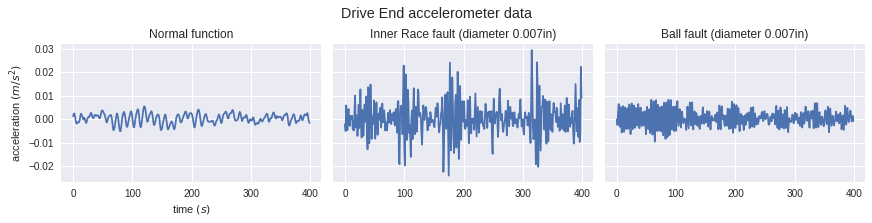

In [3]:
from deeppredict_tools import time_signal

# code=DE - drive end accelerometer data
normal_sig = time_signal(file='Normal_0', code='DE')
ir_sig = time_signal(file='IR007_0', code='DE') 
b_sig = time_signal(file='B007_0', code='DE') 

range_of_samples = range(0,400)

# plotting
import matplotlib.pyplot as plt
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,3), constrained_layout=True)
plt1.set_xlabel("time $(s)$")
plt1.set_ylabel("acceleration $(m/s^2)$")
plt1.set_title('Normal function')
plt1.plot(normal_sig[range_of_samples])
plt2.set_title('Inner Race fault (diameter 0.007in)')
plt2.plot(ir_sig[range_of_samples])
plt3.set_title('Ball fault (diameter 0.007in)')
plt3.plot(b_sig[range_of_samples])
fig.suptitle('Drive End accelerometer data')
fig.show()

### Generate the image set

Let's first generate the images, on which the Convolutional Neural Network will be trained.

We'll divide the signal in chunks of size `chunk_size`, and take a `number_of_chunks` from all the available. A chunk is simply a sequential subset of the time series data with a fixed length - the `chunk_size`. Every chunk is distinct - there are no overlapping samples in different chunks. 

This method of tumbling time windowing is elaborated on [here](https://blog.codecentric.de/en/2018/10/window-functions-in-stream-analytics/)

Further parameters we can play with and try to find the combination that works best are:
- `image_types`: this is the type of image we generate. It can be a spectrogram, a scalogram or a q-transform. We will use a spectrogram for this case, but this can easily be changed here.

- `image_shape` controls the quality of the image (number of pixels) and thus indirectly the complexity of the first convolutional layer of the network.

- `noise_scale` can be used to add some amount of noise to the signal to see how this would affect the accuracy. We'll first start without a noise.

- `shuffle_chunks_accros_time` if True, will randomise the order of the chunks. Otherwise we will be taking the chunks sequentially. This makes sense if we have a very long signal and want diversify across time. Otherwise the chunks will represent sequential time intervals of data. 


In [0]:
from deeppredict_tools import ImageType

chunk_size = 1200
number_of_chunks=1400
image_types=[ImageType.SPECTROGRAM]
image_shape = (96, 96)
shuffle_chunks_across_time=True

Now we are ready to generate the image set. The following function will generate a `image_type` type of RGBA encoded image for every chunk of data, for every of the three types of data we are going to consider. 

It will then save these values as a numpy array for performance.
> actually it's a dictionary of numpy arrays. The keys are the labels ("N", "IR", and "B") and under each label - the set of images corresponding to this type of data

In [5]:
from deeppredict_tools import create_image_by_label_database, ImageType

create_image_by_label_database(
    number_of_chunks=number_of_chunks, 
    chunk_size=chunk_size, 
    image_types=image_types, 
    image_shape=image_shape, 
    shuffle_chunks_across_time=shuffle_chunks_across_time,
    overwrite_existing_file=True)


100%|██████████| 1400/1400 [00:14<00:00, 94.90it/s]


Saving /content/gdrive/My Drive/deeppredict/npy_dataset/images_by_labels_for_cnn__chunks1400_size1200_typesSP_timeshuffled_shape96-96.npy


The function will create a file with a parametrised name that can also be used later.

Let's load it up now and take a look at the images.

In [6]:
from deeppredict_tools import load_images_by_labels_by_params, ImageType

images_by_labels = load_images_by_labels_by_params(
    chunk_size=chunk_size, 
    number_of_chunks=number_of_chunks,     
    image_types=image_types, 
    image_shape=image_shape,
    chunks_are_shuffled_across_time=shuffle_chunks_across_time)

Successfully loaded file /content/gdrive/My Drive/deeppredict/npy_dataset/images_by_labels_for_cnn__chunks1400_size1200_typesSP_timeshuffled_shape96-96.npy


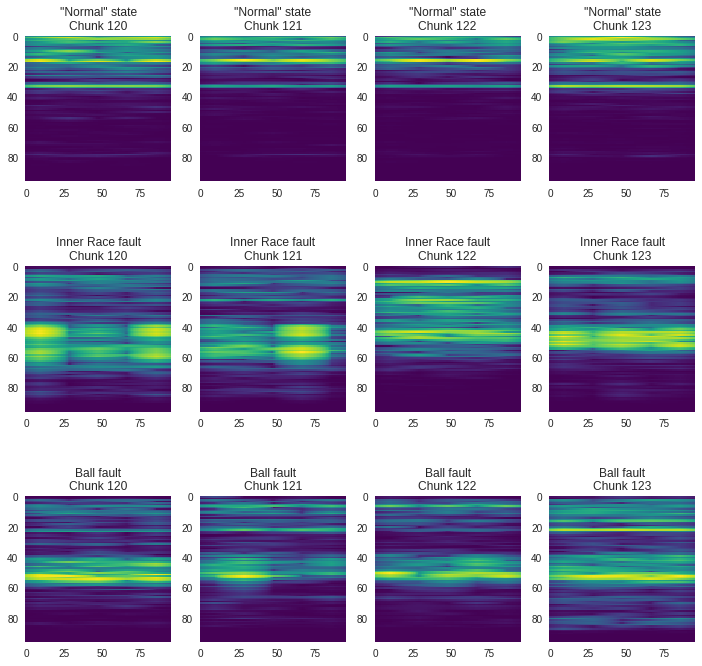

In [7]:
import matplotlib.pyplot as plt

offset = 120  # start at the {offset} chunk, somewhere within the waste of images

normal_images = images_by_labels['n']
ir_images = images_by_labels['ir']
b_images = images_by_labels['b']

plt.rcParams["axes.grid"] = False
fig = plt.figure(figsize=(12, 12))
for i in range(0, 4):  # plot so many images in a row
    plt.subplot(3, 4, i+1, title=f'"Normal" state\nChunk {offset+i}')
    plt.imshow(normal_images[offset+i])
for i in range(4, 8):  # plot so many images in a row
    plt.subplot(3, 4, i+1, title=f'Inner Race fault\nChunk {offset+i-4}')
    plt.imshow(ir_images[offset+i-4])
for i in range(8, 12):  # plot so many images in a row
    plt.subplot(3, 4, i+1, title=f'Ball fault\nChunk {offset+i-8}')
    plt.imshow(b_images[offset+i-8])
fig.show()

# Setting up the CNN model

### CNN Architecture

For this use-case we chose an architecture mimicking the Guo et al. one, described in the research article [Deep Learning Enabled Fault Diagnosis Using Time-Frequency Image Analysis of Rolling Element Bearings](https://www.hindawi.com/journals/sv/2017/5067651/)

We use the following hyperparameters:

In [8]:
from keras import optimizers

## input data parameters
IMAGES_SHAPE = (96, 96, 4)
PADDING = 'same'
KERNEL_SIZE = (5, 5)
KERNEL_INITIALIZER = 'glorot_normal'
# parameters for deep layers
NUMBER_OF_CLASSES = 3  # N, IR and B
DROPOUT = 0.5
LEAK_ALPHA = 0.1
MAX_POOLING_POOL_SIZE = (2, 2)
ACTIVATION_LAYER_FUNCTION = 'softmax'
# loss and optimizer
LOSS_FUNCTION = 'categorical_crossentropy'
LEARNING_RATE = 0.001
OPTIMIZER = optimizers.Adam(LEARNING_RATE)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


The reasons behind the choice of the hyperparameters are too broad to describe here. 

However, an example of how we found a good learning rate using the **cyclical learning rate** approach is described [in this Jupyter Notebook from our repository](https://github.com/dimitardi/deep-predict/blob/master/deeppredict_A1_finding_learning_rate.ipynb).

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import LeakyReLU
from keras import metrics


# CNN architecture from Guo et al.
model = Sequential()
model.add(Conv2D(5, KERNEL_SIZE,                  
                 input_shape=IMAGES_SHAPE,
                 data_format='channels_last',
                 kernel_initializer=KERNEL_INITIALIZER,                 
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(Conv2D(10, KERNEL_SIZE, 
                 kernel_initializer=KERNEL_INITIALIZER,
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(MaxPooling2D(pool_size=MAX_POOLING_POOL_SIZE))
model.add(Conv2D(10, KERNEL_SIZE, 
                 kernel_initializer=KERNEL_INITIALIZER,
                 padding=PADDING))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(MaxPooling2D(pool_size=MAX_POOLING_POOL_SIZE))
model.add(Flatten())
model.add(Dense(10))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(Dense(5))
model.add(LeakyReLU(LEAK_ALPHA))
model.add(Dropout(DROPOUT))
model.add(Dense(NUMBER_OF_CLASSES))
model.add(Activation(ACTIVATION_LAYER_FUNCTION))
  
model.compile(loss=LOSS_FUNCTION, 
              optimizer=OPTIMIZER,
              metrics=[metrics.categorical_accuracy])

filename_for_model = f'{DEEPPREDICT_HOME}/models/CNN_arch_guo_shape96-96-4-3__initial.h5'
model.save(filename_for_model)
print(f'Saved a new initial model at {filename_for_model}')
  
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Saved a new initial model at /content/gdrive/My Drive/deeppredict/models/CNN_arch_guo_shape96-96-4-3__initial.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 5)         505       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 5)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 10)        1260      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 96, 96, 10)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 10)        0         
______________________________________________

### Load up the images, and prepare for training

Let's load up the file we generated in step 1.

In [10]:
from deeppredict_tools import load_images_by_labels_by_params, ImageType

chunk_size = 1200
number_of_chunks=1400
image_types=[ImageType.SPECTROGRAM]
image_shape = (96, 96)
shuffle_chunks_across_time=True

images_by_labels_for_cnn = load_images_by_labels_by_params(
    chunk_size=chunk_size, 
    number_of_chunks=number_of_chunks,     
    image_types=image_types, 
    image_shape=image_shape,
    chunks_are_shuffled_across_time=shuffle_chunks_across_time)

Successfully loaded file /content/gdrive/My Drive/deeppredict/npy_dataset/images_by_labels_for_cnn__chunks1400_size1200_typesSP_timeshuffled_shape96-96.npy


Now, to transform the data to a form suitable for feeding to the CNN, we do :
- separate the images and their labels into two arrays, correlated by their indexes
- have the labels one-hot encoded (i.e. label "N" becomes (0,0,1))

Aditionally, to get a good distribution of data types accross the training and test data, we interleave the three types of data - we get a single array, containing all the images, where sequential images are always having a different data type (N, IR, or B) in the form [ ..., "N", "IR", "B", "N", "IR", "B",  ...]

In [11]:
from deeppredict_tools import separate_images_from_labels

images_for_cnn, labels_for_cnn_onehot = separate_images_from_labels(images_by_labels_for_cnn, interleave=True)

print(images_for_cnn.shape)
print(labels_for_cnn_onehot.shape)

(4200, 96, 96, 4)
(4200, 3)


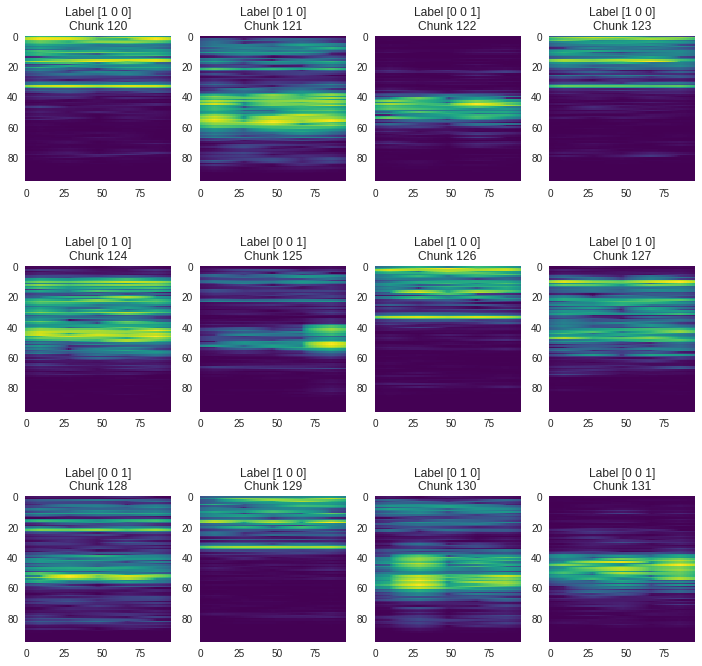

In [12]:
import matplotlib.pyplot as plt

offset = 120  # start at the {offset} chunk, somewhere within the waste of images
plt.rcParams["axes.grid"] = False
fig = plt.figure(figsize=(12, 12))
for i in range(0, 12):
    plt.subplot(3, 4, i+1, title=f'Label {labels_for_cnn_onehot[i+offset]}\nChunk {i+offset}')
    plt.imshow(images_for_cnn[i+offset])
fig.show()

The last step before training is to separate the images into training set and testing set

In [0]:
from sklearn.model_selection import train_test_split

images_train, images_test, labels_train_onehot, labels_test_onehot = \
    train_test_split(
        images_for_cnn, 
        labels_for_cnn_onehot, 
        test_size=0.33, 
        random_state=42)

Now we are ready to run the model

## **Fitting**

Let's first set the fitting parameters.

In [0]:
BATCH_SIZE = 64
NUMBER_OF_EPOCHS = 30
VALIDATION_SPLIT = 0.25

Then load up our model created in step 2, and fit it on the training data set

In [15]:
import keras

model_filename = f'{DEEPPREDICT_HOME}/models/CNN_arch_guo_shape96-96-4-3__initial.h5'
model = keras.models.load_model(model_filename)

history = model.fit(
    images_train, labels_train_onehot,
    batch_size=BATCH_SIZE,
    epochs=NUMBER_OF_EPOCHS, 
    validation_split=VALIDATION_SPLIT, 
    verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 2110 samples, validate on 704 samples
Epoch 1/30
2110/2110 [==============================] - 5s 2ms/step - loss: 4.1218 - categorical_accuracy: 0.5308 - val_loss: 0.1838 - val_categorical_accuracy: 0.9290
Epoch 2/30
2110/2110 [==============================] - 1s 690us/step - loss: 0.3585 - categorical_accuracy: 0.8365 - val_loss: 0.0541 - val_categorical_accuracy: 0.9844
Epoch 3/30
2110/2110 [==============================] - 1s 693us/step - loss: 0.2736 - categorical_accuracy: 0.8716 - val_loss: 0.0241 - val_categorical_accuracy: 0.9943
Epoch 4/30
2110/2110 [==============================] - 1s 688us/step - loss: 0.2441 - categorical_accuracy: 0.8682 - val_loss: 0.0205 - val_categorical_accuracy: 0.9972
Epoch 5/30
2110/2110 [==============================] - 1s 699us/step - loss: 0.2082 - categorical_accuracy: 0.8820 - val_loss: 0.0184 - val_categorical_accuracy: 0.9943
Epoch 6/30
2110/2110 [==============================] - 1

## Confusion matrix: Predicting the labels of the test set 

Let's see how good our model is by running it on the test set

In [16]:
# Predict the labels of the test set: y_pred
labels_predicted = history.model.predict_classes(images_test, verbose=1)

1386/1386 [==============================] - 1s 403us/step


In [17]:
# for the confusion matrix we need a factorized labels 
# [1,0,0] -> 0 ("N")
# [0,1,0] -> 1 ("IR")
# [0,0,1] -> 2 ("B")
labels_test_factorized = [(1*l[0]+2*l[1]+3*l[2])-1 for l in labels_test_onehot]

from sklearn.metrics import classification_report
print(classification_report(labels_test_factorized, labels_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       497
           1       1.00      1.00      1.00       448
           2       1.00      1.00      1.00       441

   micro avg       1.00      1.00      1.00      1386
   macro avg       1.00      1.00      1.00      1386
weighted avg       1.00      1.00      1.00      1386



We can see by that confusion matrix, that the model is having a perfect scores on our data. The reason for this is that we have very similar test and train datasets, which is causing this perfect result.

Therefore trying this technique on a more complex data (different noise levels, data with more gradual changes from normal to fault state, etc) could be the subject of our next implementation. 
